In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats

src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir, 'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
with open('/home/projects/movie-network/data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [5]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [6]:
all_movies.columns
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year']]

In [7]:
movie_producer_df = movie_producer_df.sort_values('year')

In [10]:
movie_producer_df['producer_num'] = movie_producer_df['producers'].apply(lambda x: len(x))

In [14]:
gender_df = support.get_staff_df('producers')[['_id', 'female_count', 'first_movie', 'last_movie', 'gender']]

## count occurences

### expand the producer column

In [11]:
def unlistify(df, column):
    matches = [i for i,n in enumerate(df.columns)
             if n==column]

    if len(matches)==0:
        raise Exception('Failed to find column named ' + column +'!')
    if len(matches)>1:
        raise Exception('More than one column named ' + column +'!')

    col_idx = matches[0]

    # Helper function to expand and repeat the column col_idx
    def fnc(d):
        row = list(d.values[0])
        bef = row[:col_idx]
        aft = row[col_idx+1:]
        col = row[col_idx]
        z = [bef + [c] + aft for c in col]
        return pd.DataFrame(z)

    col_idx += len(df.index.shape) # Since we will push reset the index
    index_names = list(df.index.names)
    column_names = list(index_names) + list(df.columns)
    return (df
          .reset_index()
          .groupby(level=0,as_index=0)
          .apply(fnc)
          .rename(columns = lambda i :column_names[i])
          .set_index(index_names)
          )

In [12]:
unlistyfied_producer_df = unlistify(movie_producer_df, 'producers')

In [13]:
unlistyfied_producer_df['producers'] = unlistyfied_producer_df['producers'].apply(lambda x: x[0])

## Assign genders

In [32]:
gender_df[gender_df['_id'] == 'nm0560370']

,_id,female_count,first_movie,last_movie,gender
3292,nm0560370,0,1989,1989,female


In [29]:
identifier = gender_df[['_id', 'gender']]
identifier = identifier.set_index('_id')
gender_identified_producers = unlistyfied_producer_df.join(identifier, on='producers', how='left', lsuffix="_m", rsuffix='_p')

In [63]:
gender_identified_producers.head(10)

,_id,producers,producing_gender_percentage,title,year,producer_num,gender
22884,tt0099622,nm0000339,33.333333,Full Fathom Five,1990,3,male
22884,tt0099622,nm0515891,33.333333,Full Fathom Five,1990,3,male
22884,tt0099622,nm0560370,33.333333,Full Fathom Five,1990,3,female
22502,tt0100822,nm0135847,0.000000,Tune in Tomorrow...,1990,3,male
22502,tt0100822,nm0275836,0.000000,Tune in Tomorrow...,1990,3,male
22502,tt0100822,nm0850516,0.000000,Tune in Tomorrow...,1990,3,male
10973,tt0100935,nm0326512,0.000000,Wild at Heart,1990,4,male
10973,tt0100935,nm0474138,0.000000,Wild at Heart,1990,4,male
10973,tt0100935,nm0599863,0.000000,Wild at Heart,1990,4,male
10973,tt0100935,nm0797451,0.000000,Wild at Heart,1990,4,male


### Occurences 

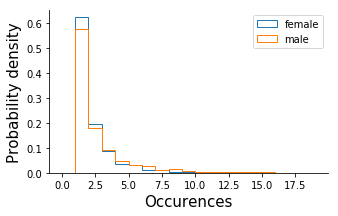

In [39]:
fig, ax = plt.subplots(figsize=(5,3))

for gender, df in gender_identified_producers.groupby('gender'):
    occurence_list = df['producers'].value_counts().values
    ax.hist(occurence_list, bins=np.arange(0, 20, 1), histtype='step', density=True, label=gender)
ax.legend(loc='upper right')
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
y_fit = stats.expon.pdf(np.arange(1, max(occurence_list), 1), loc, scale)

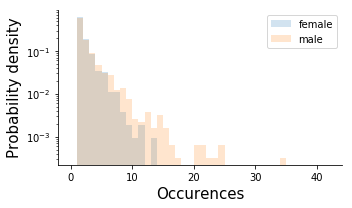

In [47]:
fig, ax = plt.subplots(figsize=(5,3))

for gender, df in gender_identified_producers.groupby('gender'):
    occurence_list = df['producers'].value_counts().values
    ax.hist(occurence_list, bins=np.arange(0, occurence_list.max(), 1), density=True, label=gender, alpha=0.2)
    
ax.legend(loc='upper right')
ax.set_yscale('log')
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
# plt.savefig('../result/90s_producer_movie_occurences_logy.pdf', dpi=300, transparent=True)

## 연도별로 여자 프로듀서가 나오는 영화 개수를 센다. 

* count all the rows with the female in gender_identified_producer
* divide by the total number of movies in the year
* identify unique movies


In [71]:
movies_with_female = {}
for year, df in gender_identified_producers.groupby('year'):
    N_movie_all = len(df._id.unique().tolist())
    N_movie_female = len(df._id[df.gender == 'female'].unique().tolist())
    movies_with_female[year] = float(N_movie_female)/N_movie_all
    

{1990: 0.453551912568306,
 1991: 0.5611111111111111,
 1992: 0.5445544554455446,
 1993: 0.5408805031446541,
 1994: 0.5706806282722513,
 1995: 0.5618556701030928,
 1996: 0.6096491228070176,
 1997: 0.6565217391304348,
 1998: 0.69377990430622,
 1999: 0.6180257510729614}

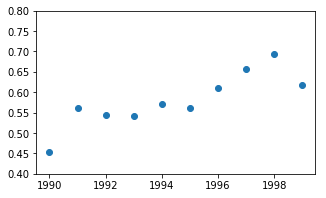

In [72]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(movies_with_female.keys(), movies_with_female.values())
ax.set_ylim([0.4, 0.8])

movies_with_female

### When the producers are randomly gender identified

In [94]:
all_producers = gender_identified_producers.producers.unique().tolist()

In [95]:
female_producers = np.random.choice(all_producers, len(f))

In [96]:
randomly_gender_assigned_df = unlistyfied_producer_df.copy(deep=True)
randomly_gender_assigned_df['gender'] = randomly_gender_assigned_df.apply(lambda row: 'female' if row.producers in female_producers else 'male', axis=1)

{1990: 0.5846994535519126,
 1991: 0.5055555555555555,
 1992: 0.48514851485148514,
 1993: 0.5345911949685535,
 1994: 0.6178010471204188,
 1995: 0.5927835051546392,
 1996: 0.5964912280701754,
 1997: 0.5956521739130435,
 1998: 0.645933014354067,
 1999: 0.6051502145922747}

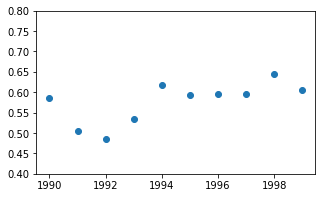

In [97]:
movies_with_female = {}
for year, df in randomly_gender_assigned_df.groupby('year'):
    N_movie_all = len(df._id.unique().tolist())
    N_movie_female = len(df._id[df.gender == 'female'].unique().tolist())
    movies_with_female[year] = float(N_movie_female)/N_movie_all
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(movies_with_female.keys(), movies_with_female.values())
ax.set_ylim([0.4, 0.8])
movies_with_female

## Movie female ratios

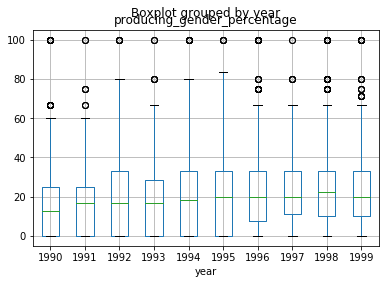

In [99]:
gender_identified_producers.boxplot(column='producing_gender_percentage', by='year')

## Gap 

In [101]:
gap_list = {}
count =0
for p, group in unlistyfied_producer_df.groupby(['producers']):
    group = group.sort_values('year')
    diff = group.year.diff().values
    gap_list[p] = list(diff[~np.isnan(diff)])

In [103]:
female_gap = []
male_gap = []
female_producers = gender_identified_producers[gender_identified_producers.gender == 'female'].producers.unique().tolist()
for p, gap in gap_list.items():
    if p in female_producers:
        female_gap.extend(gap)
    else:
        male_gap.extend(gap)

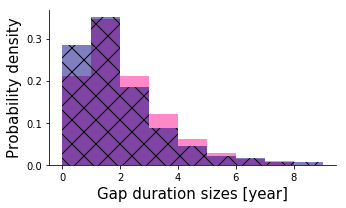

In [121]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(female_gap, bins=np.arange(0, max(female_gap)+1,1), density=True, color='deeppink', alpha=0.5)
ax.hist(male_gap, bins=np.arange(0, max(male_gap)+1,1), density=True, color='navy', alpha=0.5, hatch='X')

#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Gap duration sizes [year]', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('/home/projects/movie-network/result/basic_properties/90s_producer_movie_gaps_gender.pdf', dpi=300, transparent=True)

## Team sizes that females belong to 

(array([  0.,  58.,  88., 167., 151., 141.,  80.,  74.,  34.,  17.,  10.,
          3.,   6.,   1.,   0.,   2.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 16 Patch objects>)

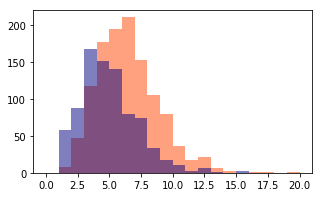

In [135]:
female_team = []
male_team = []
for movie, df in gender_identified_producers.groupby('_id'):
    producer_num = df.producer_num.values[0]
    if 'female' in df.gender.tolist():
        female_team.append(producer_num)
    else:
        male_team.append(producer_num)

fig, ax = plt.subplots(figsize=(5,3))
ax.hist(female_team, bins=np.arange(0, max(female_team)+1, 1), color='orangered', alpha=0.5)
ax.hist(male_team, bins=np.arange(0, max(male_team)+1, 1), color='navy', alpha=0.5)

In [136]:
print(np.mean(female_team), np.std(female_team))
print(np.mean(male_team), np.std(male_team))

5.937128292268479 2.4133844241258604
4.466346153846154 2.2449349218305725


### 매해 한 사람당 만드는 영화 개수

In [143]:
movies_per_year_per_producer = gender_identified_producers.groupby(['gender', 'year', 'producers']).size()

In [146]:
producers_per_year = gender_identified_producers.groupby(['gender', 'year','producers'])
len(producers_per_year)

9366

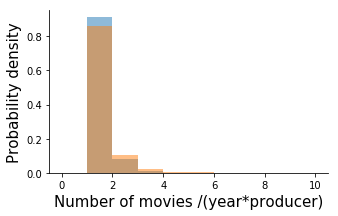

In [152]:
fig, ax = plt.subplots(figsize=(5,3))

for gender, df_gender in gender_identified_producers.groupby('gender'):
    movie_count = df_gender.groupby(['year', 'producers']).size()
    ax.hist(movie_count, bins=np.arange(0, max(movie_count)+1,1), density=True, label=gender, alpha=0.5)
    #figure style
    ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
    ax.set_xlabel('Number of movies /(year*producer)', fontsize=1.5*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

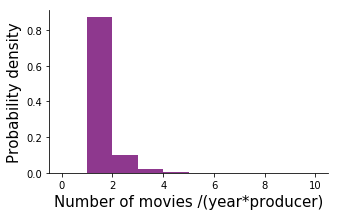

In [148]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(movie_count, bins=np.arange(0, max(movie_count)+1,1), density=True, color='#8E388E', linestyle='dashed')
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Number of movies /(year*producer)', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
# plt.tight_layout()
# plt.savefig('../result/90s_producer_movie_gaps.pdf', dpi=300, transparent=True)

In [153]:
fuck = {'a':1, 'b':2}

**fuck

SyntaxError: invalid syntax (<ipython-input-153-5a169ce1a249>, line 2)

In [ ]:
len(movie_90s)